Source: https://towardsdatascience.com/understanding-self-organising-map-neural-network-with-python-code-7a77f501e985

In [1]:
import pandas as pd
import numpy as np

In [2]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [4]:
import os
import sys

CURRENT_DIR = os.path.abspath(os.path.dirname(__name__))
LIBRARY_DIR = os.path.join(CURRENT_DIR, '.m', '.m')

sys.path.append(LIBRARY_DIR)

In [6]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [8]:
from numpy.ma.core import ceil
from scipy.spatial import distance #distance calculation
from sklearn.preprocessing import MinMaxScaler #normalisation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score #scoring
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib import animation, colors

In [9]:
data_file = "data_banknote_authentication.txt"
data_x = np.loadtxt(data_file, delimiter=",", skiprows=0, usecols=range(0,4) ,dtype=np.float64)
data_y = np.loadtxt(data_file, delimiter=",", skiprows=0, usecols=(4,),dtype=np.int64)

In [11]:
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.2, random_state=42)
# print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

In [15]:
def minmax_scaler(data):
  scaler = MinMaxScaler()
  scaled = scaler.fit_transform(data)
  return scaled

# Euclidean distance
def e_distance(x,y):
  return distance.euclidean(x,y)

# Manhattan distance
def m_distance(x,y):
  return distance.cityblock(x,y)

# Best Matching Unit search
def winning_neuron(data, t, som, num_rows, num_cols):
  winner = [0,0]
  shortest_distance = np.sqrt(data.shape[1]) # initialise with max distance
  input_data = data[t]
  for row in range(num_rows):
    for col in range(num_cols):
      distance = e_distance(som[row][col], data[t])
      if distance < shortest_distance: 
        shortest_distance = distance
        winner = [row,col]
  return winner

# Learning rate and neighbourhood range calculation
def decay(step, max_steps,max_learning_rate,max_m_distance):
  coefficient = 1.0 - (np.float64(step)/max_steps)
  learning_rate = coefficient*max_learning_rate
  neighbourhood_range = ceil(coefficient * max_m_distance)
  return learning_rate, neighbourhood_range

In [21]:
num_rows = 13
num_cols = 13
max_m_distance = 4
max_learning_rate = 0.5
max_steps = int(600)

In [22]:
#main function

train_x_norm = minmax_scaler(train_x) # normalisation

# initialising self-organising map
num_dims = train_x_norm.shape[1] # numnber of dimensions in the input data
np.random.seed(40)
som = np.random.random_sample(size=(num_rows, num_cols, num_dims)) # map construction

# start training iterations
for step in range(max_steps):
  if (step+1) % 1000 == 0:
    print("Iteration: ", step+1) # print out the current iteration for every 1k
  learning_rate, neighbourhood_range = decay(step, max_steps,max_learning_rate,max_m_distance)

  t = np.random.randint(0,high=train_x_norm.shape[0]) # random index of traing data
  winner = winning_neuron(train_x_norm, t, som, num_rows, num_cols)
  for row in range(num_rows):
    for col in range(num_cols):
      if m_distance([row,col],winner) <= neighbourhood_range:
        som[row][col] += learning_rate*(train_x_norm[t]-som[row][col]) #update neighbour's weight

print("SOM training completed")

SOM training completed


In [23]:
# collecting labels

label_data = train_y
map = np.empty(shape=(num_rows, num_cols), dtype=object)

for row in range(num_rows):
  for col in range(num_cols):
    map[row][col] = [] # empty list to store the label

for t in range(train_x_norm.shape[0]):
  if (t+1) % 1000 == 0:
    print("sample data: ", t+1)
  winner = winning_neuron(train_x_norm, t, som, num_rows, num_cols)
  map[winner[0]][winner[1]].append(label_data[t]) # label of winning neuron

sample data:  1000


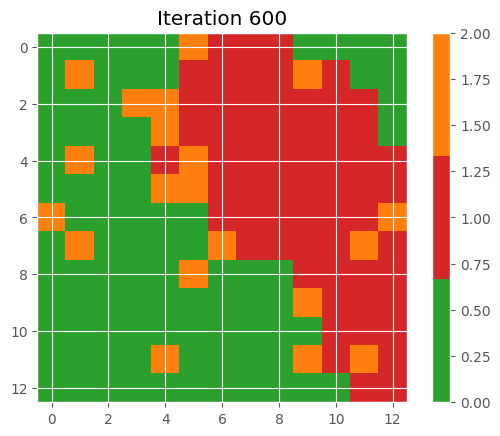

In [24]:
label_map = np.zeros(shape=(num_rows, num_cols),dtype=np.int64)
for row in range(num_rows):
  for col in range(num_cols):
    label_list = map[row][col]
    if len(label_list)==0:
      label = 2
    else:
      label = max(label_list, key=label_list.count)
    label_map[row][col] = label

title = ('Iteration ' + str(max_steps))
cmap = colors.ListedColormap(['tab:green', 'tab:red', 'tab:orange'])
plt.imshow(label_map, cmap=cmap)
plt.colorbar()
plt.title(title)
plt.show()

In [25]:
# prediction

# test data

# using the trained som, search the winning node of corresponding to the test data
# get the label of the winning node

data = minmax_scaler(test_x) # normalisation

winner_labels = []

for t in range(data.shape[0]):
 winner = winning_neuron(data, t, som, num_rows, num_cols)
 row = winner[0]
 col = winner[1]
 predicted = label_map[row][col]
 winner_labels.append(predicted)

print("Accuracy: ",accuracy_score(test_y, np.array(winner_labels)))

Accuracy:  0.9309090909090909
